# Project: Analyzing and Visualizing Airbnb Listings in a City

## import libraries

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import statistics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

### import csv file

In [32]:
df = pd.read_csv("C:/Users/IreOluwa/Desktop/jupyter/albany-airbnb-project/Data/listings.csv")

## Cleaning the data

### Removing null columns

In [33]:
updated_df = df.drop(columns=['license', 'neighbourhood_group'], axis=1)

### Handlng Missing values

In [34]:
updated_df['price'] = updated_df['price'].fillna(updated_df['price'].median())
updated_df['availability_365'] = updated_df['availability_365'].clip(lower=0)
updated_df['reviews_per_month'] = updated_df['reviews_per_month'].fillna(updated_df['reviews_per_month'].mean())
updated_df['last_review'] = updated_df['last_review'].ffill()
updated_df['number_of_reviews_ltm'] = updated_df['number_of_reviews_ltm'].fillna(updated_df['number_of_reviews_ltm'].median())

### Correcting Data Type

In [35]:
updated_df['last_review'] = pd.to_datetime(updated_df['last_review'], format='%Y-%m-%d', errors='coerce')
updated_df['neighbourhood'] = updated_df['neighbourhood'].astype('category')
updated_df['room_type'] = updated_df['room_type'].astype('category')
updated_df['availability_365'] = pd.to_numeric(updated_df['availability_365'], errors='coerce')
updated_df['number_of_reviews'] = pd.to_numeric(updated_df['number_of_reviews'], errors='coerce')
updated_df['price'] = pd.to_numeric(updated_df['price'].replace('[$]', '', regex=True).astype(float))

### Handling Outliers

In [36]:
# Calculate IQR for price
upper_limit = updated_df['price'].quantile(0.95)
cleaned_df = updated_df[updated_df['price'] <= upper_limit]
updated_df = cleaned_df.copy()

# Calculate IQR for number_of_reviews
upper_limit = updated_df['number_of_reviews'].quantile(0.95)
cleaned_df = updated_df[updated_df['number_of_reviews'] <= upper_limit]
updated_df = cleaned_df.copy()

### Binning Categorical Data

In [37]:
labels = ['Budget', 'Mid-Range', 'Luxury']
updated_df['price_category'] = pd.cut(updated_df['price'], bins=[0, 100, 175, np.inf], labels=labels)
updated_df['price_category'] = updated_df['price_category'].astype('category')
updated_df['price_category'].value_counts()

price_category
Budget       248
Mid-Range    124
Luxury        30
Name: count, dtype: int64

## Model for Price Prediction (ML)

### Data Preprocessing

#### Encoding Categorical Data

In [38]:
updated_df_encoded = pd.get_dummies(updated_df, columns=['neighbourhood', 'room_type'], drop_first=True)

#### Features and Target

In [39]:
features = ['number_of_reviews', 'number_of_reviews_ltm', 'availability_365', 'minimum_nights'] + \
           [col for col in updated_df_encoded.columns if col.startswith('neighbourhood_') or col.startswith('room_type_')]
X = updated_df_encoded[features]
y = updated_df_encoded['price']

#### Scale Numeric Features

In [40]:
scaler = StandardScaler()
X[['number_of_reviews', 'number_of_reviews_ltm', 'availability_365', 'minimum_nights']] = scaler.fit_transform(X[['number_of_reviews', 'number_of_reviews_ltm', 'availability_365', 'minimum_nights']])

C:\Users\IreOluwa\AppData\Local\Temp\ipykernel_6704\1995601741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['number_of_reviews', 'number_of_reviews_ltm', 'availability_365', 'minimum_nights']] = scaler.fit_transform(X[['number_of_reviews', 'number_of_reviews_ltm', 'availability_365', 'minimum_nights']])


### Data Splitting

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

Training set size: (321, 19), Test set size: (81, 19)


### Training

In [42]:
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Evaluation

In [43]:
lr_pred = lr_model.predict(X_test)
rf_pred = rf_model.predict(X_test)

# Evaluation for Linear Regression
print("\nLinear Regression Perfomance:")
print(f"MAE: {mean_absolute_error(y_test, lr_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, lr_pred):.2f}")
print(f"R-Squared: {r2_score(y_test, lr_pred):.2f}")

# Evaluation for Random Forest Regression
print("\nRandom Forest Regression Performance:")
print(f"MAE: {mean_absolute_error(y_test, rf_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, rf_pred):.2f}")
print(f"R-Squared: {r2_score(y_test, rf_pred):.2f}")


Linear Regression Perfomance:
MAE: 32.06
MSE: 1890.39
R-Squared: 0.17

Random Forest Regression Performance:
MAE: 26.09
MSE: 1411.64
R-Squared: 0.38


#### Visualization

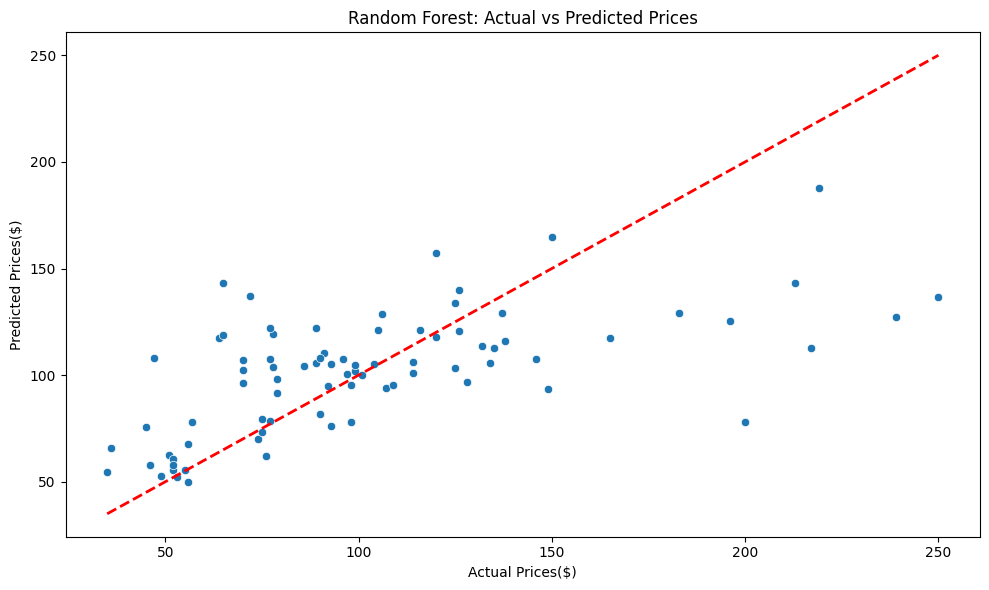

In [44]:
# Scatter plot of Actual vs Predicted Prices

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=rf_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Random Forest: Actual vs Predicted Prices')
plt.xlabel('Actual Prices($)')
plt.ylabel('Predicted Prices($)')
plt.tight_layout()
#plt.savefig('actual_vs_predicted_prices.png')
plt.show()

### Feature Importance (Random Forest)

In [45]:
# To analyze which features (eg, 'neighbourhood', 'room_type) most influenced price predictions

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)
feature_importance

,feature,importance
18,room_type_Private room,0.216615
2,availability_365,0.207567
0,number_of_reviews,0.156364
3,minimum_nights,0.117511
1,number_of_reviews_ltm,0.097855
5,neighbourhood_FIFTEENTH WARD,0.034791
13,neighbourhood_SIXTH WARD,0.030392
14,neighbourhood_TENTH WARD,0.029005
4,neighbourhood_ELEVENTH WARD,0.022490
17,neighbourhood_TWELFTH WARD,0.016408


#### Visualize Feature Importance

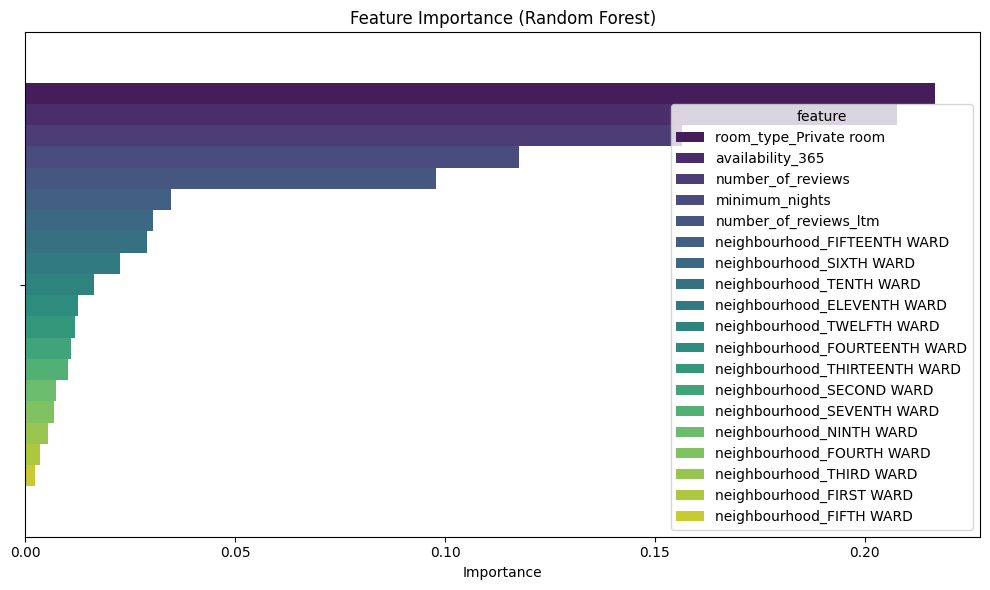

In [46]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', hue='feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
#plt.savefig('feature_importance.png')
plt.show()